# Exchangeability and Bayesian Updating

In [1]:
from numba import njit, vectorize
from math import gamma
import scipy.optimize as op
from scipy.integrate import quad
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
@vectorize
def p(x, a, b):
    "The general beta distribution function."
    r = gamma(a + b) / (gamma(a) * gamma(b))
    return r * x ** (a-1) * (1 - x) ** (b-1)

def learning_example(F_a=1, F_b=1, G_a=3, G_b=1.2):
    """
    A wrapper function that displays the updating rule of belief π,
    given the parameters which specify F and G distributions.
    """

    f = njit(lambda x: p(x, F_a, F_b))
    g = njit(lambda x: p(x, G_a, G_b))

    # l(w) = f(w) / g(w)
    l = lambda w: f(w) / g(w)
    # objective function for solving l(w) = 1
    obj = lambda w: l(w) - 1

    x_grid = np.linspace(0, 1, 100)
    π_grid = np.linspace(1e-3, 1-1e-3, 100)

    w_max = 1
    w_grid = np.linspace(1e-12, w_max-1e-12, 100)

    # the mode of beta distribution
    # use this to divide w into two intervals for root finding
    G_mode = (G_a - 1) / (G_a + G_b - 2)
    roots = np.empty(2)
    roots[0] = op.root_scalar(obj, bracket=[1e-10, G_mode]).root
    roots[1] = op.root_scalar(obj, bracket=[G_mode, 1-1e-10]).root

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))

    ax1.plot(l(w_grid), w_grid, label='$l$', lw=2)
    ax1.vlines(1., 0., 1., linestyle="--")
    ax1.hlines(roots, 0., 2., linestyle="--")
    ax1.set_xlim([0., 2.])
    ax1.legend(loc=4)
    ax1.set(xlabel='$l(w)=f(w)/g(w)$', ylabel='$w$')

    ax2.plot(f(x_grid), x_grid, label='$f$', lw=2)
    ax2.plot(g(x_grid), x_grid, label='$g$', lw=2)
    ax2.vlines(1., 0., 1., linestyle="--")
    ax2.hlines(roots, 0., 2., linestyle="--")
    ax2.legend(loc=4)
    ax2.set(xlabel='$f(w), g(w)$', ylabel='$w$')

    area1 = quad(f, 0, roots[0])[0]
    area2 = quad(g, roots[0], roots[1])[0]
    area3 = quad(f, roots[1], 1)[0]

    ax2.text((f(0) + f(roots[0])) / 4, roots[0] / 2, f"{area1: .3g}")
    ax2.fill_between([0, 1], 0, roots[0], color='blue', alpha=0.15)
    ax2.text(np.mean(g(roots)) / 2, np.mean(roots), f"{area2: .3g}")
    w_roots = np.linspace(roots[0], roots[1], 20)
    ax2.fill_betweenx(w_roots, 0, g(w_roots), color='orange', alpha=0.15)
    ax2.text((f(roots[1]) + f(1)) / 4, (roots[1] + 1) / 2, f"{area3: .3g}")
    ax2.fill_between([0, 1], roots[1], 1, color='blue', alpha=0.15)

    W = np.arange(0.01, 0.99, 0.08)
    Π = np.arange(0.01, 0.99, 0.08)

    ΔW = np.zeros((len(W), len(Π)))
    ΔΠ = np.empty((len(W), len(Π)))
    for i, w in enumerate(W):
        for j, π in enumerate(Π):
            lw = l(w)
            ΔΠ[i, j] = π * (lw / (π * lw + 1 - π) - 1)

    q = ax3.quiver(Π, W, ΔΠ, ΔW, scale=2, color='r', alpha=0.8)

    ax3.fill_between(π_grid, 0, roots[0], color='blue', alpha=0.15)
    ax3.fill_between(π_grid, roots[0], roots[1], color='green', alpha=0.15)
    ax3.fill_between(π_grid, roots[1], w_max, color='blue', alpha=0.15)
    ax3.hlines(roots, 0., 1., linestyle="--")
    ax3.set(xlabel='$\pi$', ylabel='$w$')
    ax3.grid()

    plt.show()

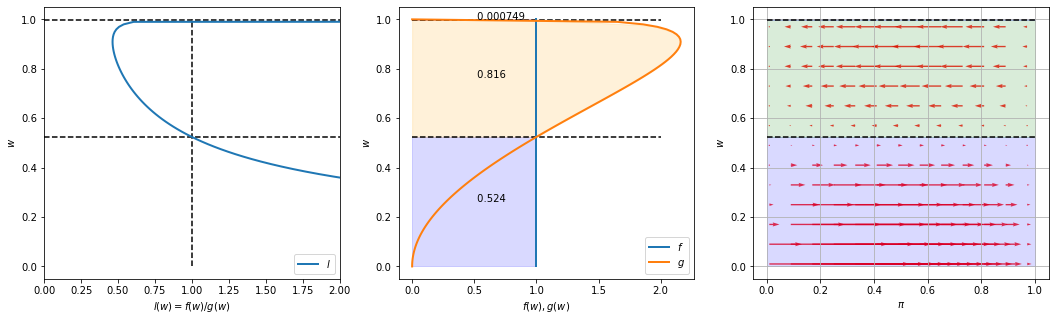

In [3]:
learning_example()

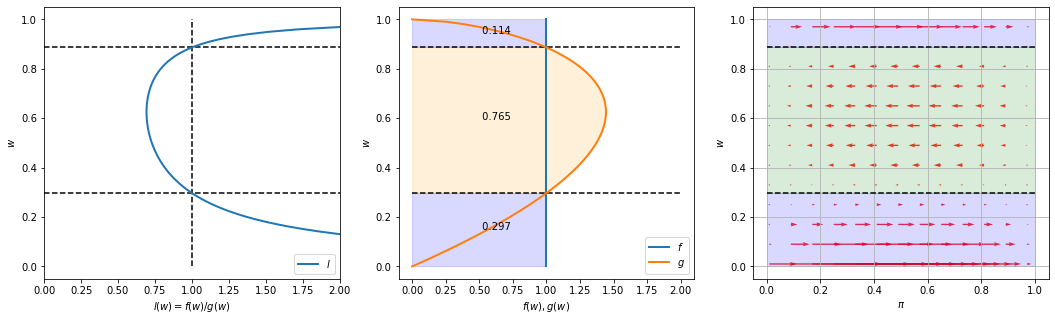

In [4]:
learning_example(G_a=2, G_b=1.6)

In [5]:
def function_factory(F_a=1, F_b=1, G_a=3, G_b=1.2):

    # define f and g
    f = njit(lambda x: p(x, F_a, F_b))
    g = njit(lambda x: p(x, G_a, G_b))

    @njit
    def update(a, b, π):
        "Update π by drawing from beta distribution with parameters a and b"

        # Draw
        w = np.random.beta(a, b)

        # Update belief
        π = 1 / (1 + ((1 - π) * g(w)) / (π * f(w)))

        return π

    @njit
    def simulate_path(a, b, T=50):
        "Simulates a path of beliefs π with length T"

        π = np.empty(T+1)

        # initial condition
        π[0] = 0.5

        for t in range(1, T+1):
            π[t] = update(a, b, π[t-1])

        return π

    def simulate(a=1, b=1, T=50, N=200, display=True):
        "Simulates N paths of beliefs π with length T"

        π_paths = np.empty((N, T+1))
        if display:
            fig = plt.figure()

        for i in range(N):
            π_paths[i] = simulate_path(a=a, b=b, T=T)
            if display:
                plt.plot(range(T+1), π_paths[i], color='b', lw=0.8, alpha=0.5)

        if display:
            plt.show()

        return π_paths

    return simulate

In [6]:
simulate = function_factory()

In [7]:
T = 50

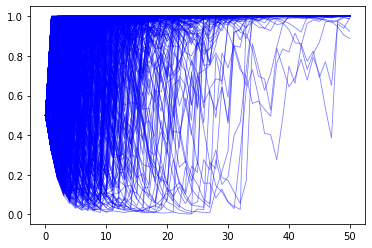

In [8]:
# when nature selects F
π_paths_F = simulate(a=1, b=1, T=T, N=1000)

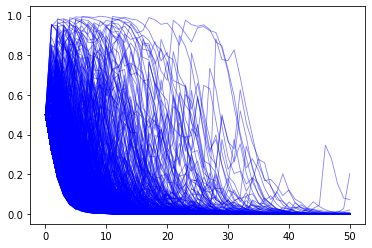

In [9]:
# when nature selects G
π_paths_G = simulate(a=3, b=1.2, T=T, N=1000)

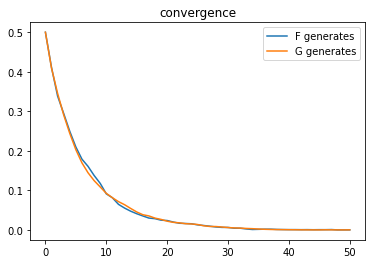

In [10]:
plt.plot(range(T+1), 1 - np.mean(π_paths_F, 0), label='F generates')
plt.plot(range(T+1), np.mean(π_paths_G, 0), label='G generates')
plt.legend()
plt.title("convergence");

In [11]:
def expected_ratio(F_a=1, F_b=1, G_a=3, G_b=1.2):

    # define f and g
    f = njit(lambda x: p(x, F_a, F_b))
    g = njit(lambda x: p(x, G_a, G_b))

    l = lambda w: f(w) / g(w)
    integrand_f = lambda w, π: f(w) * l(w) / (π * l(w) + 1 - π)
    integrand_g = lambda w, π: g(w) * l(w) / (π * l(w) + 1 - π)

    π_grid = np.linspace(0.02, 0.98, 100)

    expected_rario = np.empty(len(π_grid))
    for q, inte in zip(["f", "g"], [integrand_f, integrand_g]):
        for i, π in enumerate(π_grid):
            expected_rario[i]= quad(inte, 0, 1, args=(π,))[0]
        plt.plot(π_grid, expected_rario, label=f"{q} generates")

    plt.hlines(1, 0, 1, linestyle="--")
    plt.xlabel("$π_t$")
    plt.ylabel("$E[\pi_{t+1}/\pi_t]$")
    plt.legend()

    plt.show()

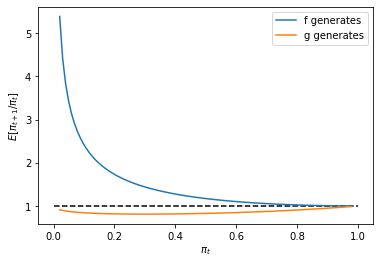

In [12]:
expected_ratio()

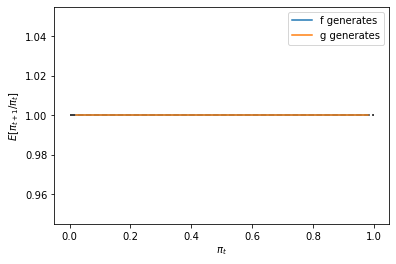

In [13]:
expected_ratio(F_a=3, F_b=1.2)

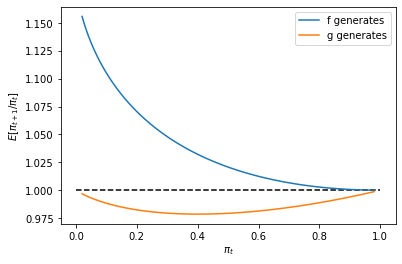

In [14]:
expected_ratio(F_a=2, F_b=1, G_a=3, G_b=1.2)